In [ ]:
from logging import getLogger
import traceback
import argparse
import os
import pandas as pd
import ollama
import chromadb
import requests
from reportparse.structure.document import Document
import re
from reportparse.rags.db_rag.db import ChromaDBHandler
from langchain_groq import ChatGroq
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from pymongo import MongoClient

In [2]:
# Connect to MongoDB
print("Connecting to MongoDB...")
client = MongoClient("mongodb://localhost:27017/")
db = client["pdf_annotations"]
collection = db["annotations"]
print("Connected to MongoDB.")

# Fetch the document from MongoDB
pdf_id = "example.pdf"  # Replace with your actual PDF name
document_data = collection.find_one({"name": pdf_id})

if document_data:
    # Convert MongoDB document to ReportParse format
    document = Document.from_dict(document_data)

    # Convert to DataFrame at the 'page' level
    df = document.to_dataframe_ext(level='page')
    
    print("DataFrame created successfully.")
else:
    print(f"Document '{pdf_id}' not found in the database.")
    print("Loading from file...")
    document = Document.from_json_file('./results/example.pdf.json')
    df = document.to_dataframe_ext(level='page')
    print(df)
print()


Connecting to MongoDB...
Connected to MongoDB.
Document 'example.pdf' not found in the database.
Loading from file...
      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  2480.316671   
1  page_idx_1         1  4405.499776  2480.316671   
2  page_idx_2         2  4405.499776  2480.316671   
3  page_idx_3         3  4405.499776  2480.316671   
4  page_idx_4         4  4405.499776  2480.316671   
5  page_idx_5         5  4405.499776  2480.316671   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   
5  054 Hitachi Sustainability Report 2023 Environ...   

                                          first_pass  \
0  Company Name: Hitachi Ltd.\n\nPotential greenw...   
1  Co

In [3]:
print(df.columns)


Index(['page_id', 'page_num', 'page_width', 'page_height', 'page_text',
       'first_pass', 'meta_first_pass_info', 'chroma_result_claim_0',
       'meta_chroma_result_claim_0_claim',
       'meta_chroma_result_claim_0_retrieved_pages',
       ...
       'meta_aggregator_2_result_claim_1_label',
       'meta_aggregator_2_result_claim_1_justification',
       'meta_aggregator_2_result_claim_1_faith_eval',
       'meta_aggregator_2_result_claim_1_groundedness_eval',
       'meta_aggregator_2_result_claim_1_readability_eval',
       'meta_aggregator_2_result_claim_1_redundancy_eval',
       'meta_aggregator_2_result_claim_1_specificity_eval',
       'meta_aggregator_2_result_claim_1_compression_ratio_eval',
       'meta_aggregator_2_result_claim_1_lexical_diversity_eval',
       'meta_aggregator_2_result_claim_1_noun_to_verb_ratio_eval'],
      dtype='object', length=131)


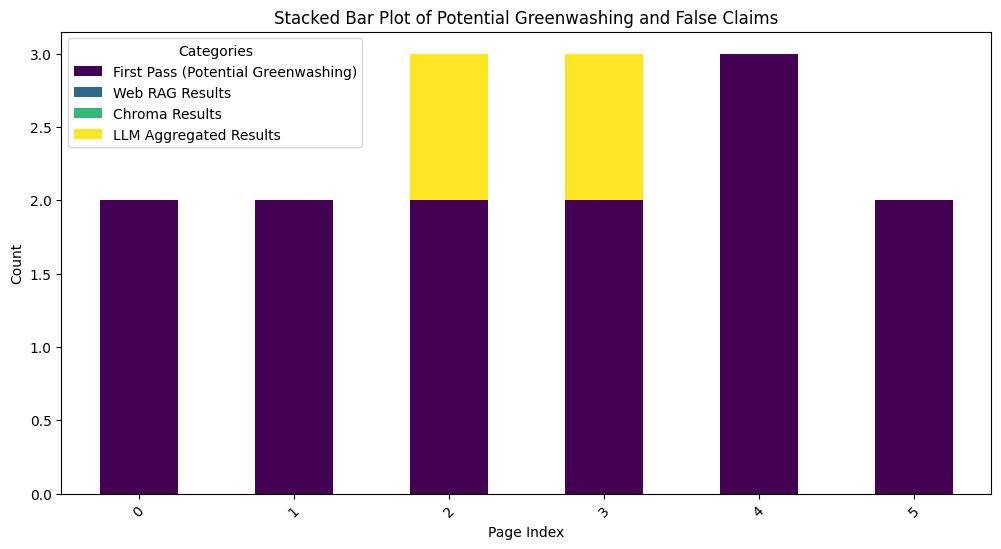

In [ ]:
# Count occurrences of "Potential greenwashing" in the "First pass" column per page
first_pass_count = df["first_pass"].str.count("Potential greenwashing", flags=re.IGNORECASE).groupby(df.index).sum()

def count_false_statements(columns, df):
    return df[columns].apply(lambda col: col.str.contains("FALSE", na=False)).sum(axis=1)

# **Dynamically find relevant columns** for each category
web_rag_columns = [col for col in df.columns if col.startswith("web_rag_result")]
chroma_columns = [col for col in df.columns if col.startswith("chroma_result")]
aggregator_columns = [col for col in df.columns if col.startswith("aggregator_result")]

# Count false claims for each category
web_rag_count = count_false_statements(web_rag_columns, df)
chroma_count = count_false_statements(chroma_columns, df)
llm_agg_count = count_false_statements(aggregator_columns, df)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    "First Pass (Potential Greenwashing)": first_pass_count,
    "Web RAG Results": web_rag_count,
    "Chroma Results": chroma_count,
    "LLM Aggregated Results": llm_agg_count
})

# Plot stacked bar chart
ax = plot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Page Index")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Potential Greenwashing and False Claims")
plt.legend(title="Categories")
plt.xticks(np.arange(len(plot_df.index)), plot_df.index, rotation=45)
plt.show()



In [8]:
import pandas as pd
import re

def analyze_claims(df):
    # Get all column names that match the expected pattern
    claim_cols = [col for col in df.columns if re.match(r"meta_cti_results_\d+_claim", col)]
    print(claim_cols)
    results = []
    total_non_specific_commitment_yes = 0
    total_commitment_yes = 0

    for idx, row in df.iterrows():
        print(f"Processing Page: {idx}")
        
        # Extract the unique claim indices from the claim columns
        claim_set = set(re.findall(r"meta_cti_results_(\d+)_", " ".join(claim_cols)))
        print("claim set", claim_set)
        total_claims = len(claim_set)
        print("Total claims:", total_claims)
        # Filter out claims that have missing detection values
        for claim_idx in claim_set:
            detection_column = f'meta_cti_results_{claim_idx}_cti_metrics_climate'
            
            detection_value = row.get(detection_column, None)
            
            # If the detection_value is a list or array, extract the first element (tuple) and check for NaN
            if isinstance(detection_value, list) and len(detection_value) > 0:
                detection_value = detection_value[0][0]  # Extract the first element of the tuple, e.g., "yes"
            
            # If the detection value is NaN, ignore this claim
            if pd.isna(detection_value):
                total_claims -= 1
                
        print("Marked claims:", total_claims, "Page:", idx)
        commitment_yes = 0
        detection_yes = 0
        non_specific_commitment_yes = 0

        for i in range(total_claims):
            detection_col = f"meta_cti_results_{i}_cti_metrics_climate"
            commitment_col = f"meta_cti_results_{i}_cti_metrics_commitment"
            specificity_col = f"meta_cti_results_{i}_cti_metrics_specificity"

            detection = row.get(detection_col, [])
            commitment = row.get(commitment_col, [])
            specificity = row.get(specificity_col, [])

            # extract the first value from tuples if they exist (tuples have both label and confidence score)
            detection_label = detection[0][0] if isinstance(detection, list) and detection else None
            commitment_label = commitment[0][0] if isinstance(commitment, list) and commitment else None
            specificity_label = specificity[0][0] if isinstance(specificity, list) and specificity else None

            if detection_label == "yes":
                detection_yes += 1

            if commitment_label == "yes":
                commitment_yes += 1
                total_commitment_yes += 1
                if specificity_label == "non":
                    non_specific_commitment_yes += 1
                    total_non_specific_commitment_yes += 1

        # Compute the fraction
        ratio = (non_specific_commitment_yes / commitment_yes) if commitment_yes > 0 else None

        results.append({
            "page_id": row["page_id"],
            "total_claims": total_claims,
            "commitment_yes": commitment_yes,
            "detection_yes": detection_yes,
            "non_specific_commitment_yes": non_specific_commitment_yes,
            "non_specific_commitment_ratio": ratio
        })

    # Compute the overall CTI
    overall_cti = total_non_specific_commitment_yes / total_commitment_yes if total_commitment_yes > 0 else None

    return pd.DataFrame(results), overall_cti

cti_df, overall_cti = analyze_claims(df)

print(cti_df)
print()
if overall_cti is not None:
    print(f"Overall CTI: {overall_cti}")
else:
    print("Overall CTI: N/A")

['meta_cti_results_0_claim', 'meta_cti_results_1_claim']
Processing Page: 0
claim set {'0', '1'}
Total claims: 2
Marked claims: 2 Page: 0
Processing Page: 1
claim set {'0', '1'}
Total claims: 2
Marked claims: 2 Page: 1
Processing Page: 2
claim set {'0', '1'}
Total claims: 2
Marked claims: 2 Page: 2
Processing Page: 3
claim set {'0', '1'}
Total claims: 2
Marked claims: 2 Page: 3
Processing Page: 4
claim set {'0', '1'}
Total claims: 2
Marked claims: 2 Page: 4
Processing Page: 5
claim set {'0', '1'}
Total claims: 2
Marked claims: 2 Page: 5
      page_id  total_claims  commitment_yes  detection_yes  \
0  page_idx_0             2               1              2   
1  page_idx_1             2               2              2   
2  page_idx_2             2               1              2   
3  page_idx_3             2               2              2   
4  page_idx_4             2               2              2   
5  page_idx_5             2               1              2   

   non_specific_commit

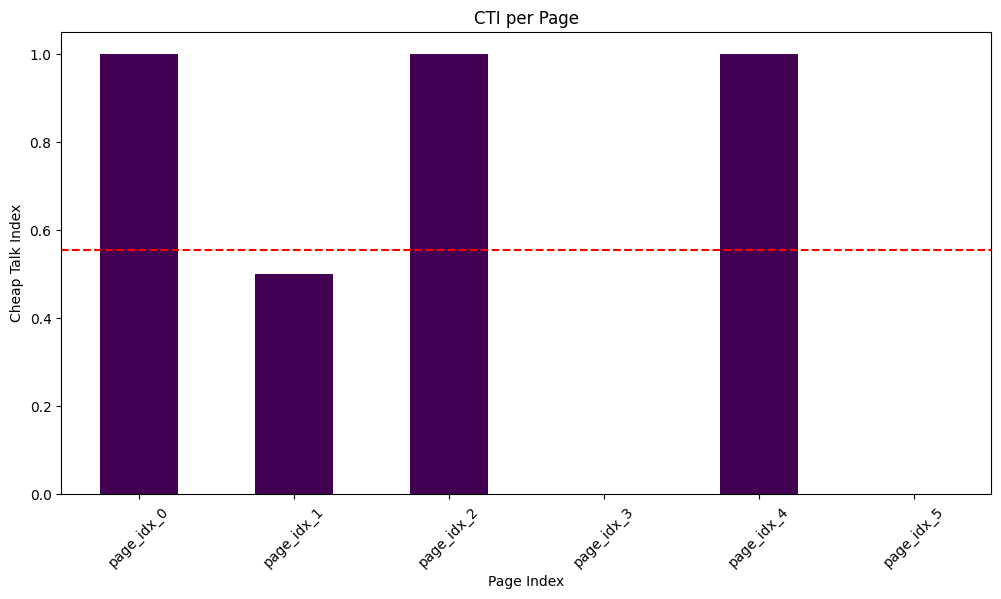

Overall CTI: 0.5556


In [9]:
# bar plot summary_df["non_specific_commitment_ratio"] and overall cti
cti_df["non_specific_commitment_ratio"].plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.axhline(y=overall_cti, color='red', linestyle='--', label=f'Overall CTI: {overall_cti:.4f}')
plt.xlabel("Page Index")
plt.ylabel("Cheap Talk Index")
plt.title("CTI per Page")
plt.xticks(np.arange(len(cti_df.index)), cti_df["page_id"], rotation=45)
plt.show()

print(f"Overall CTI: {overall_cti:.4f}")


In [10]:
document = Document.from_json_file('./results/example.pdf.json')
df_2 = document.to_dataframe(level="block")

climate_df = df_2[df_2["climate"] == "yes"]

cti_df = climate_df.groupby("page_id").apply(
    lambda x: pd.Series({
        "commit_total": (x["climate_commitment"] == "yes").sum(),
        "commit_non_spec": ((x["climate_commitment"] == "yes") & (x["climate_specificity"] == "non")).sum()
    })
)

# Calculate CTI
cti_df["CTI"] = cti_df["commit_non_spec"] / cti_df["commit_total"]
cti_df["CTI"].fillna(0, inplace=True)

cti_df.reset_index(inplace=True)

print(cti_df)

# for the whole document
total_commit = (climate_df["climate_commitment"] == "yes").sum()
total_commit_non_spec = ((climate_df["climate_commitment"] == "yes") & (climate_df["climate_specificity"] == "non")).sum()
overall_cti = total_commit_non_spec / total_commit if total_commit > 0 else 0

print(f"Overall Cheap Talk Index (CTI): {overall_cti:.4f}")

cti_results = {
    "page_cti_scores": cti_df.set_index("page_id")["CTI"].to_dict(),
    "overall_cti": overall_cti
}
input_base = "example.pdf.json"
output_path = f"./cli_results/{input_base}_cti_scrores.json"

with open(output_path, "w") as f:
    json.dump(cti_results, f, indent=4)

print(f"CTI scores saved to {output_path}")


page_ids = list(cti_results["page_cti_scores"].keys())
page_scores = list(cti_results["page_cti_scores"].values())

plt.figure(figsize=(12, 6))

sns.barplot(x=page_ids, y=page_scores, palette="Blues_r")

plt.axhline(y=overall_cti, color='red', linestyle='--', label=f'Overall CTI: {overall_cti:.4f}')

plt.xlabel("Page ID")
plt.ylabel("CTI Score")
plt.title("Cheap Talk Index (CTI) per Page")
plt.xticks(rotation=90)  
plt.legend()

plt.tight_layout()
plt.show()

# save plot in the same dir
plt.savefig(f"./cli_results/{input_base}_cti_plot.png")


KeyError: 'climate'